### [View on nbviewer](https://nbviewer.jupyter.org/github/chrisluedtke/divvy-data-analysis/blob/master/notebook.ipynb)

In [24]:
%matplotlib inline
import folium
import folium.plugins
import numpy as np
import pandas as pd

import divvy

### Initial Data Sourcing

In [2]:
rides, stations = divvy.historical_data.get_data(
    year=[str(_) for _ in range(2013,2019)],
    rides=True, 
    stations=True
)

rides.to_pickle('data/rides.pkl')
stations.to_pickle('data/stations.pkl')

### Load from Pickle

In [3]:
rides = pd.read_pickle('data/rides.pkl')
# drop unused cols to save space
rides = rides.drop(columns=['from_station_name', 'to_station_name'])

In [4]:
stations = pd.read_pickle('data/stations.pkl')

### Exploration

In [4]:
rides.dtypes

bikeid                        int64
birthday                    float64
birthyear                   float64
end_time             datetime64[ns]
from_station_id               int64
from_station_name            object
gender                       object
start_time           datetime64[ns]
to_station_id                 int64
to_station_name              object
trip_id                       int64
tripduration                float64
usertype                     object
dtype: object

In [5]:
rides.isna().sum()

bikeid                      0
birthday             17022431
birthyear             4730951
end_time                    0
from_station_id             0
from_station_name           0
gender                4335754
start_time                  0
to_station_id               0
to_station_name             0
trip_id                     0
tripduration                0
usertype                    0
dtype: int64

count    6386.000000
mean     2728.678359
std       871.209718
min         2.000000
25%      2059.250000
50%      2779.500000
75%      3427.000000
max      5164.000000
Name: bikeid, dtype: float64


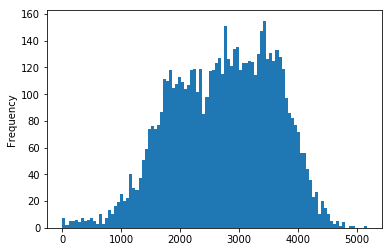

In [117]:
# How many times has each bike been ridden?
bike_use = rides['bikeid'].value_counts()
print(bike_use.describe())
bike_use.plot.hist(bins=100);

In [4]:
def get_all_groups(how='Q', start='2013-01-01', end='2018-12-31'):
    all_dates = pd.date_range(start, end, freq='D')
    all_dates = (pd.Series(all_dates)
                   .dt.to_period(how)
                   .drop_duplicates())
    
    return pd.Series(data=0, index=all_dates)

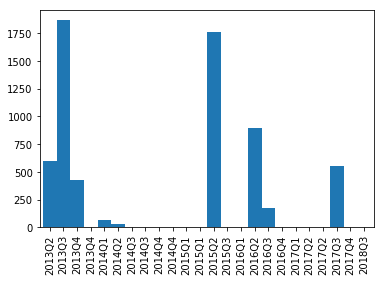

In [5]:
# Count of first month bike used
color=(31/256,119/256,180/256,1)

frst_use = (rides.groupby('bikeid')['start_time'].first()
                 .dt.to_period("Q"))
frst_use.name = 'first_use_quarter'

data = frst_use.value_counts()

data = data.append(get_all_groups(how='Q'))
data = (data.sort_values(ascending=False)
            .loc[~data.index.duplicated(keep='first')]
            .sort_index())

data.plot.bar(color=color, width=1);

In [ ]:
# color bike usage by quarter first ridden
rides = rides.merge(frst_use.astype(str), left_on='bikeid',
                    right_on=frst_use.index)

In [10]:
cols = ['first_use_quarter', 'bikeid']
bike_use = rides[cols].sort_values('first_use_quarter')

bike_use_grp = (bike_use.groupby('first_use_quarter')['bikeid'].value_counts()
                        .reset_index(name='n_rides')
                        .drop(columns='bikeid'))

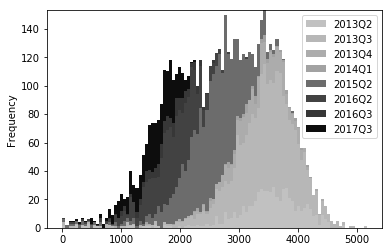

In [147]:
color_dict = {}
all_groups = get_all_groups()

for i, v in enumerate(all_groups.index):
    color_dict[str(v)] = (
        .8-i/len(all_groups), 
        .8-i/len(all_groups), 
        .8-i/len(all_groups), 
        1
    )
    
colors = [color_dict.get(group) for group in bike_use_grp.first_use_quarter.unique()]

d = {}
for k, v in bike_use_grp.groupby('first_use_quarter').n_rides:
    if len(v) > 31:
        d[k] = v
        
hist = pd.DataFrame(d)

hist.plot.hist(bins=100, stacked=True, color=[color_dict[col] for col in hist.columns]);

In [8]:
len(rides)

17425340

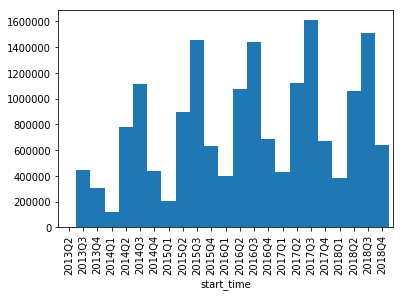

In [118]:
# Count of quarterly rides
(rides['start_time'].groupby([rides.start_time
                                   .dt.to_period("Q")])
                    .count()
                    .plot.bar(color=color, width=1));

In [7]:
706/60

11.766666666666667

In [6]:
rides.tripduration.describe()

count    1.742534e+07
mean     1.092654e+03
std      1.643426e+04
min      6.000000e+01
25%      4.110000e+02
50%      7.060000e+02
75%      1.197000e+03
max      1.433640e+07
Name: tripduration, dtype: float64

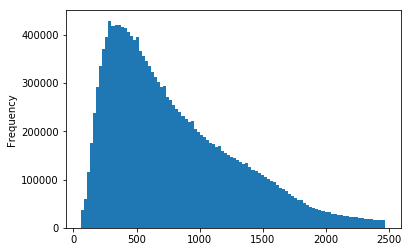

In [120]:
# How long are trips?
(rides.tripduration.loc[rides.tripduration < rides.tripduration.quantile(.95)]
                   .plot.hist(bins=100));

## Get Station Coordinates

In [9]:
stations = pd.read_pickle('data/stations.pkl')

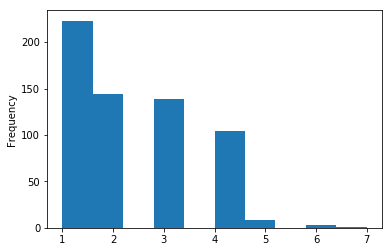

In [10]:
# Stations have moved
(stations.drop_duplicates(['id', 'latitude', 'longitude'])
         .groupby('id')['id'].count()
         .plot.hist());

Unfortunately, Divvy kept the same station ID while physically moving those stations around. This adds a lot of complexity to route analysis, and it makes certain analyses impossible.

One approach may be to round lat/lon coordinates to some [degree of precision](https://en.wikipedia.org/wiki/Decimal_degrees#Precision), and then remove duplicates on rounded position. While that may seem to reduce the problem, there would be no way to determine whether a station initially at position A, moved to position B, and then back to position A.

Another approach is to calculate the rolling difference of lat/lon coordinates and filter out differences below a desired precision. Let's do that.

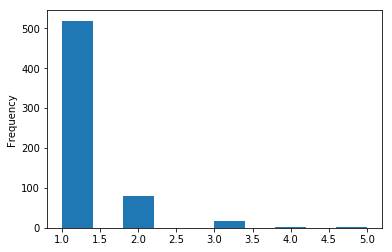

In [16]:
fix_stns = stations.copy()
diffs = (fix_stns.sort_values('source')
                 .groupby('id')
                 .agg({'latitude':'diff',
                       'longitude':'diff'})
                 .assign(sum_diff=lambda df: abs(df.latitude) + 
                                             abs(df.longitude))
                 .drop(columns=['latitude', 'longitude']))

fix_stns = pd.concat([fix_stns, diffs], axis=1)
# NaNs are first instance, so keep those
fix_stns = fix_stns.loc[fix_stns.sum_diff.isna() | (fix_stns.sum_diff > 0.0005)]

dupe_counts = fix_stns.groupby('id')['id'].count()
dupe_counts.plot.hist();

We can assess the problem by plotting stations that have moved:

In [28]:
df = fix_stns.loc[fix_stns.id.duplicated(keep=False), 
              ['id', 'latitude', 'longitude', 
               'online_date', 'source']]

m = folium.Map(location=[df.latitude.mean(), 
                         df.longitude.mean()],
               tiles='CartoDB dark_matter',
               zoom_start=12)

grouped = df.groupby('id')
for k, v in grouped:
    points = list(zip(v.latitude, v.longitude))
    folium.PolyLine(
        points, tooltip=str(v.id.values[0]),
        color="#E37222", weight=1
    ).add_to(m)
    
folium.plugins.Fullscreen(
    position='topright',
    title='Expand me',
    title_cancel='Exit me',
    force_separate_button=True
).add_to(m)
    
m

In [29]:
m.save('moved.html')

In [15]:
print(grouped.get_group(2))

      id   latitude  longitude          online_date     source
3464   2  41.872293 -87.624091  2015-12-31 23:59:59       2015
2334   2  41.881060 -87.619486  2013-06-10 10:43:46  2017_Q1Q2
0      2  41.876393 -87.620328  2013-06-10 10:43:00  2017_Q3Q4


From here I would create a lookup table for stations that have moved. The rows would span each day the station was active, and I would merge with my `rides` table on a `ride_id_date` key. Here's the start to that process:

In [18]:
# station_dates = pd.concat([rides[['start_time', 'to_station_id']].rename(columns={'to_station_id':'station_id'}), 
#                            rides[['start_time', 'from_station_id']].rename(columns={'from_station_id':'station_id'})], 
#                           ignore_index=True)

# station_dates = (station_dates.sort_values('start_time')
#                               .groupby('station_id')
#                               .agg({'start_time':['min', 'max']}))

But for now, I'll average each duplicated station's lat/lon positions to make things easy.

In [17]:
stations = (fix_stns.groupby('id')['latitude', 'longitude']
                .mean())

In [18]:
rides = (rides.merge(stations.rename(columns={'latitude':'from_lat',
                                              'longitude':'from_lon'}),
                     left_on='from_station_id', right_index=True,
                     how='left')
              .merge(stations.rename(columns={'latitude':'to_lat',
                                              'longitude':'to_lon'}),
                     left_on='to_station_id', right_index=True,
                     how='left'))

In [19]:
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371000):
    """
    Vectorized great circle distance between two points
    (lat, lon) specified in decimal degrees or in radians)
    Returns units in meters
    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

In [20]:
rides['dist'] = haversine(rides.from_lat, rides.from_lon, rides.to_lat, rides.to_lon)

In [21]:
rides.dist.describe()

count    1.742475e+07
mean     2.005762e+03
std      1.587529e+03
min      0.000000e+00
25%      9.254459e+02
50%      1.548781e+03
75%      2.646230e+03
max      3.679380e+04
Name: dist, dtype: float64

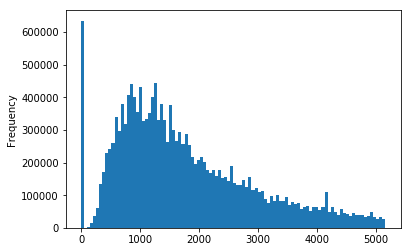

In [36]:
rides.dist.loc[rides.dist < rides.dist.quantile(.95)].plot.hist(bins=100);

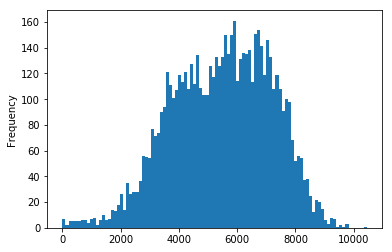

In [37]:
# sum distance ridden
dist_sum = rides.groupby('bikeid')['dist'].sum().divide(1000)
dist_sum.plot.hist(bins=100);

In [38]:
dist_sum.sort_values(ascending=False)

bikeid
410     10451.034962
1315     9785.608171
1385     9743.838634
73       9726.479546
877      9642.728393
2240     9586.680666
774      9537.659454
555      9417.218802
1445     9405.346914
94       9380.165405
2241     9370.453664
2147     9368.991225
1487     9361.754246
2155     9361.315722
1378     9356.319125
238      9289.824865
1876     9283.878905
2283     9279.702646
1735     9264.411279
688      9253.965965
1587     9236.256683
1136     9229.251760
579      9215.316213
421      9182.588288
473      9148.954574
1774     9142.743539
1245     9084.495100
1796     9051.738711
414      9044.715829
872      9024.249290
            ...     
5596      646.147172
6121      612.479608
4265      606.424150
6428      606.294858
5869      547.247352
842       529.852904
6063      522.370701
4212      485.359022
4321      454.732640
335       453.007622
2351      432.142886
1551      414.484579
5147      398.582973
6413      361.533281
4014      355.692798
4155      329.369938
5364  

In [41]:
# Path of the longest farthest bike
df = (rides.loc[(rides.bikeid==410)]
           .sort_values('start_time'))

In [45]:
points = []
for from_i, to_i, in zip(list(zip(df.from_lat, df.from_lon)), 
                         list(zip(df.to_lat, df.to_lon))):
    points.append(from_i)
    points.append(to_i)
    
m = folium.Map(location=[df.from_lat.mean(), 
                         df.from_lon.mean()],
               tiles='CartoDB dark_matter',
               zoom_start=12)

folium.PolyLine(
    points,
    weight=0.2,
    color="#E37222"
).add_to(m)

folium.plugins.Fullscreen(
    position='topright',
    title='Expand me',
    title_cancel='Exit me',
    force_separate_button=True
).add_to(m)

m

In [46]:
m.save('longest_ridden.html')

In [101]:
rides.columns

Index(['bikeid', 'birthyear', 'end_time', 'from_station_id', 'gender',
       'start_time', 'to_station_id', 'trip_id', 'tripduration', 'usertype',
       'id', 'from_lat', 'from_lon', 'to_lat', 'to_lon', 'dist', 'hour',
       'from_hour', 'from_dow'],
      dtype='object')

In [307]:
# check DST
dst_start = { # clock 2AM to 3AM
    '2013':'2013-03-10',
    '2014':'2013-03-09',
    '2015':'2013-03-08',
    '2016':'2016-03-13',
    '2017':'2017-03-12',
    '2018':'2018-03-11',
}

dst_end = { # clock 2AM to 1AM
    '2013':'2013-11-03',
    '2014':'2014-11-02',
    '2015':'2015-11-01',
    '2016':'2016-11-06',
    '2017':'2017-11-05',
    '2018':'2018-11-04',
}

for year in [str(_) for _ in range(2013,2019)]:
    print(
        rides.loc[(f'{dst_start[year]} 02:00:00' < rides.start_time) &
              (rides.start_time < f'{dst_start[year]} 02:59:59'), cols]
    )
    
print(rides.loc[(rides.end_time < rides.start_time), cols])

Empty DataFrame
Columns: [trip_id, start_time, end_time, tripduration]
Index: []
Empty DataFrame
Columns: [trip_id, start_time, end_time, tripduration]
Index: []
Empty DataFrame
Columns: [trip_id, start_time, end_time, tripduration]
Index: []
Empty DataFrame
Columns: [trip_id, start_time, end_time, tripduration]
Index: []
Empty DataFrame
Columns: [trip_id, start_time, end_time, tripduration]
Index: []
Empty DataFrame
Columns: [trip_id, start_time, end_time, tripduration]
Index: []


In [ ]:
# size = number of uses per day active
# color = type of use

In [ ]:
rides_sm = rides.sample(1000)

In [173]:
# actually half hour
rides['from_hour'] = (rides.start_time.dt.hour + 
                      rides.start_time.dt.minute // 30 * 0.5)
rides['from_dow'] = rides.start_time.dt.dayofweek
rides['from_month'] = rides.start_time.dt.year + rides.start_time.dt.month/12
rides['end_hour'] = (rides.end_time.dt.hour + 
                     rides.end_time.dt.minute // 30 * 0.5)
rides['end_dow'] = rides.end_time.dt.dayofweek
rides['end_month'] = rides.end_time.dt.year + rides.end_time.dt.month/12

In [10]:
departures = (rides.groupby('from_hour')['from_station_id']
                   .value_counts()
                   .reset_index(name='departures')
                   .rename(columns={
                       'from_station_id':'station_id',
                       'from_hour':'hour'
                   }))

arrivals = (rides.groupby('end_hour')['to_station_id']
                 .value_counts()
                 .reset_index(name='arrivals')
                 .rename(columns={
                     'to_station_id':'station_id',
                     'end_hour':'hour'
                 }))

In [240]:
stn_days_act = (rides.loc[:, ['from_station_id', 'from_month']]
                     .rename(columns={'from_station_id':'station_id',
                                      'from_month':'month'})
                     .append(rides_sm.loc[:, ['to_station_id', 'end_month']]
                                     .rename(columns={'to_station_id':'station_id',
                                                      'end_month':'month'}))
                     .groupby('station_id')['month'].nunique()) * 30
stn_days_act.name = 'days_active'

In [548]:
stn_hr_agg = (arrivals.merge(departures, on=['hour', 'station_id'], how='outer')
                      .assign(net=lambda df: df.arrivals - df.departures)
                      .merge(stations, 
                             left_on='station_id', 
                             right_index=True)
                      .merge(stn_days_act, left_on='station_id', 
                             right_index=True)
                      .fillna(0))

stn_hr_agg['avg_usage'] = ((stn_hr_agg.arrivals + stn_hr_agg.departures) / 
                           stn_hr_agg.days_active)
stn_hr_agg['pt_departures'] = (stn_hr_agg.departures / 
                               (stn_hr_agg.arrivals + stn_hr_agg.departures)) - 0.50 

In [253]:
(set(rides.to_station_id) | set(rides.from_station_id)) - set(stn_hr_agg.station_id)

{360, 361, 363, 512, 647}

In [255]:
(set(rides.to_station_id) | set(rides.from_station_id)) - set(stations.index)

{360, 361, 363, 512}

In [422]:
def hex2rgb(color:str):
    """HEX-code to decimal"""
    return tuple(int(color.lstrip('#')[i:i+2], 16) for i in (0, 2 ,4))

def dec2hex(n):
    """Decimal number to HEX str"""
    if (n > 16):
        return str(hex(n).split('x')[-1])
    else:
        return "0" + str(hex(n).split('x')[-1])

def get_gradient(start, stop, steps, include_inputs=False):
    """Gradient between hex color start and stop"""
    r, g, b = hex2rgb(start)
    r2, g2, b2 = hex2rgb(stop)
    r_step = int((r2 - r) / steps)
    g_step = int((g2 - g) / steps)
    b_step = int((b2 - b) / steps)
    
    grd_lst = []
    for i in range(steps):
        r += r_step
        g += g_step
        b += b_step
        grd_lst.append("#" + dec2hex(r) + 
                       dec2hex(g) + dec2hex(b))
    
    if include_inputs:
        return [start] + grd_lst + [stop]
    else:
        return grd_lst

In [402]:
def add_empty_rows(stn_hr_agg, expctd_elems):
    ffill_cols = ['station_id','latitude','longitude']
    id_cols = ['station_id', 'hour']
    nan_cols = ['avg_usage','pt_departures']
    
    uniq_stns = (stn_hr_agg.loc[:, ffill_cols]
                           .drop_duplicates())
    uniq_stns.index = [1]*len(uniq_stns)

    hr_elems = pd.Series(expctd_elems, 
                         index=[1]*len(expctd_elems),
                         name='hour')
    df = (pd.merge(hr_elems, uniq_stns, 
                   left_index=True, right_index=True)
            .sort_values(id_cols)
            .reset_index(drop=True)
            .merge(stn_hr_agg[id_cols+nan_cols], on=id_cols,
                   how='outer'))
    return df

def interpolate(df: pd.DataFrame):
    # 0.033333333 is 30 frames per hour of IRL observations
    # place zero values
    set_zeros = np.linspace(0,24,24*2, endpoint=False)
    df = add_empty_rows(df, set_zeros)
    df = df.fillna(0)
    # place nan values
    set_nans = np.linspace(0,24,24*2*15, endpoint=False).round(3)
    df = add_empty_rows(df, set_nans)
    # add final frame that matches first frame
    df = (df.append((df.loc[df.hour==0,:]
                       .assign(hour=24.000))))
    # interpolate nans
    df = df.sort_values(['station_id', 'hour']).interpolate()
    return df

In [549]:
df = interpolate(stn_hr_agg)

In [594]:
# Merge in color values
# pt_departures:
#0.85: "#f06e18"
#0.50: "#e6e6e6"
#0.15: "#18f0da"
strt_color = "#18f0da" #blue, gathering bikes  "#0A8A9F" # teal
mid_color = "#e6e6e6" #grey
end_color = "#f06e18" #orange, "radiating" bikes  "#E37222" # tangerine
start_pos = 25
mid_width = 5

steps = int((100-start_pos*2-mid_width)/2) + 1

color_list = ([strt_color] * start_pos +
              get_gradient(strt_color, mid_color, steps) + 
              [mid_color] * mid_width +
              get_gradient(mid_color, end_color, steps) + 
              [end_color] * start_pos)
gradient = pd.Series(data=color_list,
                     index=(np.linspace(-0.5, 0.5, 101,
                                        endpoint=True)
                              .round(2)),
                     name='color')

In [551]:
df.loc[df.pt_departures==0]

,hour,station_id,latitude,longitude,avg_usage,pt_departures
825,3.500,3,41.867226,-87.615355,0.020741,0.0
855,4.500,3,41.867226,-87.615355,0.026667,0.0
1890,15.000,4,41.856268,-87.613348,5.009091,0.0
5040,0.000,11,41.766638,-87.576450,0.012403,0.0
5041,0.033,11,41.766638,-87.576450,0.012093,0.0
5042,0.067,11,41.766638,-87.576450,0.011783,0.0
5043,0.100,11,41.766638,-87.576450,0.011473,0.0
5044,0.133,11,41.766638,-87.576450,0.011163,0.0
5045,0.167,11,41.766638,-87.576450,0.010853,0.0
5046,0.200,11,41.766638,-87.576450,0.010543,0.0


In [596]:
df['pt_departures'] = df.pt_departures.round(2)
if 'color'in df:
    df = df.drop(columns='color')
df = df.merge(gradient, left_on='pt_departures', right_index=True)

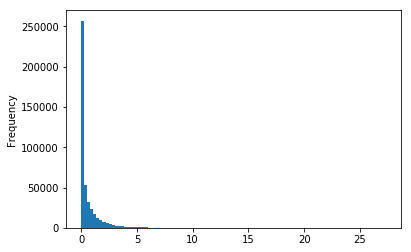

In [438]:
# dot size range
df.avg_usage.plot.hist(bins=100);

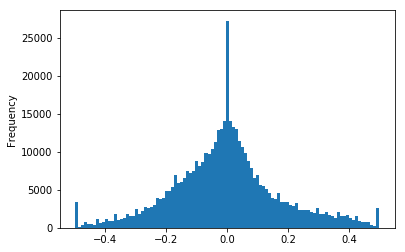

In [602]:
# dot color range
df.pt_departures.plot.hist(bins=101);

In [475]:
df['area'] = df.avg_usage.divide(np.pi).pow(1/2)
# df.radius.plot.hist(bins=100);

In [583]:
def gen_maps_by_hour(df, zoom=12, height_px=1350,
                     width_px=1350, circle_line_weight=0.5, 
                     min_radius=0.5, max_radius=None,
                     radius_scalar=1, radius_pow=1, show_tooltip=False,
                     radius_label='radius', preview=True, hour=None):
    if preview and hour:
        df = df.loc[df.hour==hour, :]
        
    grouped_df = df.groupby('hour')
    
    for group, df in grouped_df:
        m = folium.Map(location=[41.90, -87.66],
                       zoom_start=zoom,
                       width=width_px,
                       height=height_px,
                       zoom_control=False,
                       tiles="CartoDB dark_matter")

        for i, r in df.iterrows():
            radius = (min_radius + 
                      r[radius_label]**radius_pow*radius_scalar)
            
            if max_radius and radius > max_radius:
                radius = max_radius
            if show_tooltip:
                tooltip=(f'{radius_label}: {round(r[radius_label],3)}<br>'
                         f'% depart: {round((r.pt_departures+0.5)*100,3)}')
            else:
                tooltip=None
                
            folium.CircleMarker(location=(r.latitude,
                                          r.longitude),
                                radius=radius,
                                color=r['color'],
                                weight=circle_line_weight,
                                tooltip=tooltip,
                                fill=True).add_to(m)
        if preview:
            return m
        else:
            m.save(f"maps/{str(int(group*100)).zfill(5)}.html")

In [603]:
gen_maps_by_hour(df, zoom=12, height_px=1350, width_px=int(1350*1.777), 
                 circle_line_weight=0.5, 
                 min_radius=2, radius_scalar=4, radius_pow=1, 
                 max_radius=24, radius_label='avg_usage', 
                 preview=False, hour=17,
                 show_tooltip=True)

In [415]:
# gen_maps_by_hour(zoom=13, height_px=3000, radius_scale=1.2,
#                  width_px=2000, circle_line_weight=0.8)

In [47]:
# render maps to images
import os
import time
from selenium import webdriver

maps_fldr = os.path.join(os.getcwd(), 'maps')
output_dir = os.path.join(os.getcwd(), 'img', 'maps')

def render_maps_img(map_x_px, map_y_px, maps_fldr, 
                    output_dir, sleep_s=3.5):
    browser = webdriver.Firefox()
    browser.set_window_size(map_x_px, map_y_px+100)
    
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)

    for map_fn in os.listdir(maps_fldr):
        map_path = os.path.join(maps_fldr, map_fn)
        if map_fn.endswith('.html'):
            browser.get(f'file://{map_path}')
            time.sleep(sleep_s)

            to_fn = map_fn.replace('.html', '.png')
            to_fn = os.path.join(output_dir, to_fn)
            browser.save_screenshot(to_fn)
            print(f'Wrote: {to_fn}')

    browser.quit()

In [ ]:
import datetime, io, od
from PIL import Image, ImageDraw, ImageFont

time_font = ImageFont.truetype("Roboto-Thin.ttf", 120)

img_dir = os.path.join(os.getcwd(), r'img\maps\2019-02-07_good')
save_dir = os.path.join(os.getcwd(), r'img\maps\2019-02-07_text')

if not os.path.exists(save_dir):
    os.mkdir(save_dir)
    
for png in os.listdir(img_dir)[-1:]:
    image = Image.open(os.path.join(img_dir, png))
    draw = ImageDraw.ImageDraw(image)

    hour = int(png[1:3])
    minute = round(float(png[3:5]+png[-5]+png[-5])/10000*60)
    
    if hour == 24:
        time_fix = (datetime.datetime(2019, 1, 1, 0, minute) + 
                    datetime.timedelta(minutes=15))
    else:
        time_fix = (datetime.datetime(2019, 1, 1, hour, minute) + 
                    datetime.timedelta(minutes=15))

    draw.line((image.width-200, image.height, image.width-200, 0),
              fill=(38, 38, 38), width=350)

    draw.text((image.width-1040,image.height - 875), 
              time_fix.strftime('%I:%M %p'),
              fill=(100, 100, 100), 
              font=time_font)

    image = image.crop((12, 20, image.width, image.height-26))
    filename = os.path.join(save_dir, f"frame_{str(hour).zfill(2)}_{str(minute).zfill(2)}.png")
    image.save(filename, "PNG")
#     image.show()